# Modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

In [4]:
def append_results(result, train_score, metric, classifier):
    tmp = pd.DataFrame({
        'model':classifier,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        #'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [5]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc
    }
    fig, axes = plt.subplots(ncols=2, figsize=(13,5))
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['WNV Present (1)','WNV Not Present (0)'], ax=axes[0]);
    roc_curve = plot_roc_curve(classifier, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values()
        })
    return metrics

In [3]:
train_comb = pd.read_csv('./assets/train_comb.csv')

In [6]:
train_comb['date'] = pd.to_datetime(train_comb['date'])
train_comb.set_index('date', inplace=True)

In [7]:
# dropping trap column for now as it is not numeralize yet
X = train_comb.drop(columns=['wnvpresent', 'trap'])
y = train_comb['wnvpresent']

In [8]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# Scale X data
ss = StandardScaler()
Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

## Baseline Score

In [10]:
train_comb['wnvpresent'].value_counts(normalize=True)

0    0.944966
1    0.055034
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.948.

In [11]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'test_accuracy',
    'misclassification',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'roc_auc'
])

## Account for Imbalanced Class

We note from our target column: 'wnvpresent' that there is massive class imbalance. We can resolve this by using SMOTE and embed it within a pipeline.

In [12]:
# sm = SMOTE()

In [13]:
# Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

## Logistic Regression

In [14]:
# instantiate pipeline
pipe_logreg = Pipeline([('sampling', SMOTE()),
                ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [15]:
# set params to gridsearch
# sampling params set to comment because it was taking too long to fit
pipe_logreg_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [0.5, 1, 1.5, 2],
#    'sampling__sampling_strategy': ['minority', 'auto'],
#    'sampling__k_neighbors': [3, 5],
}

In [16]:
gs_logreg = GridSearchCV(pipe_logreg, pipe_logreg_params, verbose=2, n_jobs=-1)

In [17]:
%%time
gs_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 10.6 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.5, 1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2']},
             verbose=2)

In [18]:
gs_logreg.best_params_

{'logreg__C': 0.5, 'logreg__penalty': 'l1'}

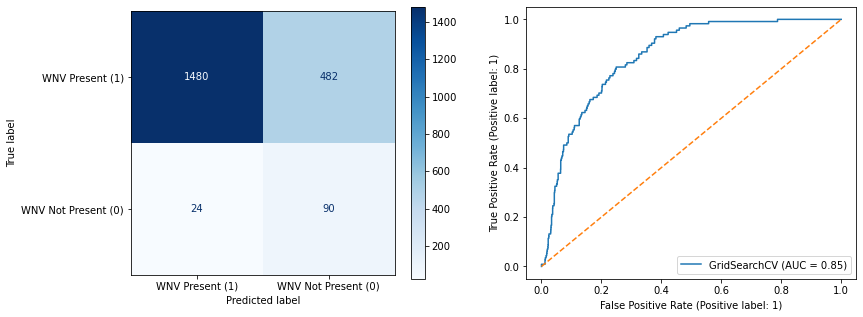

In [19]:
mod_metrics = metrics_and_plot_cm(gs_logreg, Xs_val, y_val)

In [20]:
results_df = append_results(results_df,
                           gs_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'Logistic Regression',
                           )

In [21]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.755459,0.756262,0.243738,0.789474,0.754332,0.157343,0.262391,0.851818


## SVM

In [22]:
# instantiate pipeline
pipe_svc = Pipeline([('sampling', SMOTE()),
                 ('svc', SVC(probability=True, random_state=100)) # probability=True is needed to calculate predict_proba but fitting grid model would take very long
                ])

In [23]:
pipe_svc_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  #'poly'
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [24]:
gs_svc = GridSearchCV(pipe_svc, pipe_svc_params, verbose=2, n_jobs=-1)

In [25]:
%%time
gs_svc.fit(Xs_train, y_train)

# wall time is cut by half we dont put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 36.3 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'svc__C': [5, 7, 9], 'svc__kernel': ['rbf']},
             verbose=2)

In [26]:
gs_svc.best_params_

{'svc__C': 9, 'svc__kernel': 'rbf'}

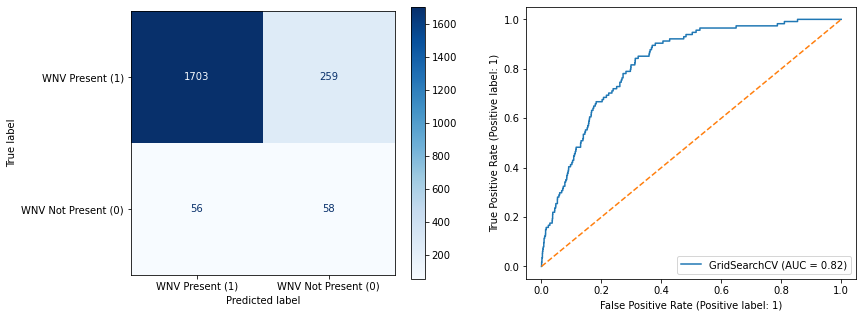

In [27]:
mod_metrics = metrics_and_plot_cm(gs_svc, Xs_val, y_val)

In [28]:
results_df = append_results(results_df,
                           gs_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'SVM',
                           )

In [29]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.755459,0.756262,0.243738,0.789474,0.754332,0.157343,0.262391,0.851818
1,SVM,0.890495,0.848266,0.151734,0.508772,0.867992,0.182965,0.269142,0.822266


## PCA

In [30]:
# instantiate pca
pca = PCA(random_state=100)

In [31]:
pca.fit(Xs_train)

PCA(random_state=100)

In [32]:
Z_train, Z_val = pca.transform(Xs_train), pca.transform(Xs_val)

In [33]:
pca.explained_variance_ratio_.round(3)

array([0.263, 0.152, 0.096, 0.071, 0.054, 0.041, 0.039, 0.037, 0.036,
       0.03 , 0.028, 0.027, 0.025, 0.02 , 0.019, 0.019, 0.013, 0.011,
       0.008, 0.005, 0.003, 0.002, 0.001, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [34]:
pca.explained_variance_ratio_.round(3)[:10].sum()

0.8190000000000002

We see that the first 10 components explain 77% of the variance.

In [35]:
pca.explained_variance_ratio_.round(3)[:25].sum()

1.001

The first 25 component explain 100% of the variance.

### Logistic Regression with PCA

In [36]:
# embed pca in a pipeline
pipe_pca_logreg = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [37]:
pipe_pca_logreg_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [1, 1.5, 2],
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],
}

In [38]:
gs_pca_logreg = GridSearchCV(pipe_pca_logreg, pipe_pca_logreg_params, verbose=2, n_jobs=-1)

In [39]:
%%time
gs_pca_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.75096276 0.74983981        nan 0.75192713 0.74726991        nan
 0.74855518 0.75144507        nan 0.74871531 0.75032058        nan
 0.75288983 0.75032006        nan 0.75096392 0.75417419        nan]
  warnings.warn(


Wall time: 4.74 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [20, 30, 40]},
             verbose=2)

In [40]:
gs_pca_logreg.best_params_

{'logreg__C': 2, 'logreg__penalty': 'l2', 'pca__n_components': 30}

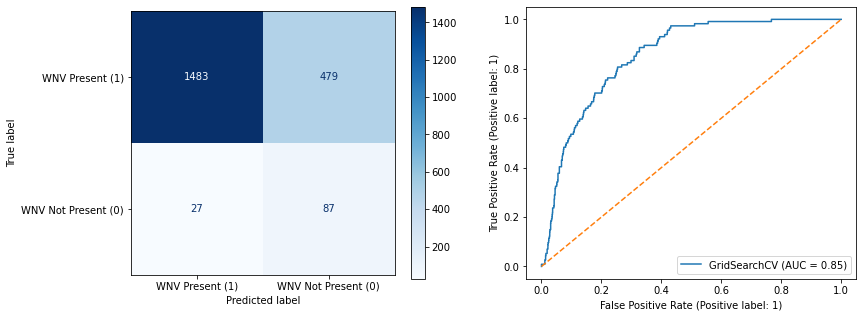

In [41]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [42]:
results_df = append_results(results_df,
                           gs_pca_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA Logistic Regression',
                           )

In [43]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.755459,0.756262,0.243738,0.789474,0.754332,0.157343,0.262391,0.851818
1,SVM,0.890495,0.848266,0.151734,0.508772,0.867992,0.182965,0.269142,0.822266
2,PCA Logistic Regression,0.754817,0.756262,0.243738,0.763158,0.755861,0.153710,0.255882,0.852842


### SVM with PCA

In [44]:
pipe_pca_svc = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('svc', SVC(probability=True, random_state=100))
])

In [45]:
pipe_pca_svc_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  # 'poly'
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [46]:
gs_pca_svc = GridSearchCV(pipe_pca_svc, pipe_pca_svc_params, verbose=2, n_jobs=-1)

In [47]:
%%time
gs_pca_svc.fit(Xs_train, y_train)

## lol example of time taken (14 mins) if we put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8627161  0.86335931 0.86368098 0.86351892 0.86400034 0.86737267
        nan        nan        nan]
  warnings.warn(


Wall time: 45.4 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [20, 30, 40], 'svc__C': [5, 7, 9],
                         'svc__kernel': ['rbf']},
             verbose=2)

In [48]:
gs_pca_svc.best_params_

{'pca__n_components': 30, 'svc__C': 9, 'svc__kernel': 'rbf'}

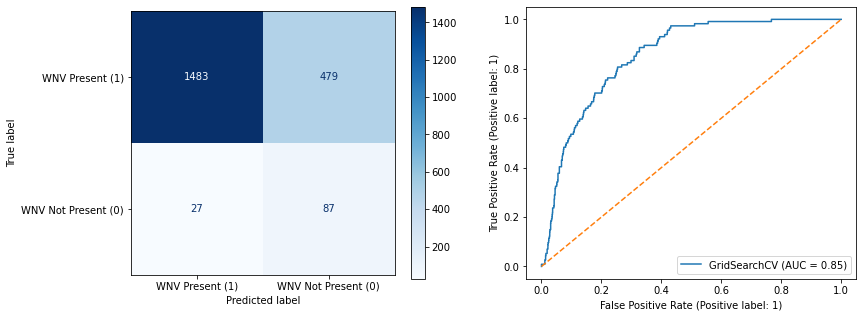

In [49]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [50]:
results_df = append_results(results_df,
                           gs_pca_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA SVM',
                           )

In [51]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.755459,0.756262,0.243738,0.789474,0.754332,0.157343,0.262391,0.851818
1,SVM,0.890495,0.848266,0.151734,0.508772,0.867992,0.182965,0.269142,0.822266
2,PCA Logistic Regression,0.754817,0.756262,0.243738,0.763158,0.755861,0.153710,0.255882,0.852842
3,PCA SVM,0.895472,0.756262,0.243738,0.763158,0.755861,0.153710,0.255882,0.852842


## AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [64]:
pipe_ada = Pipeline([
    ('sampling', SMOTE()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))
])

In [65]:
pipe_ada_params = {
    'ada__n_estimators': [50,100,150],
    'ada__learning_rate': [0.1,1,10]
}

In [66]:
gs_ada = GridSearchCV(pipe_ada, pipe_ada_params, verbose=1, n_jobs=-1)

In [67]:
gs_ada.fit(Xs_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.1, 1, 10],
                         'ada__n_estimators': [50, 100, 150]},
             verbose=1)

In [68]:
gs_ada.best_params_

{'ada__learning_rate': 0.1, 'ada__n_estimators': 100}

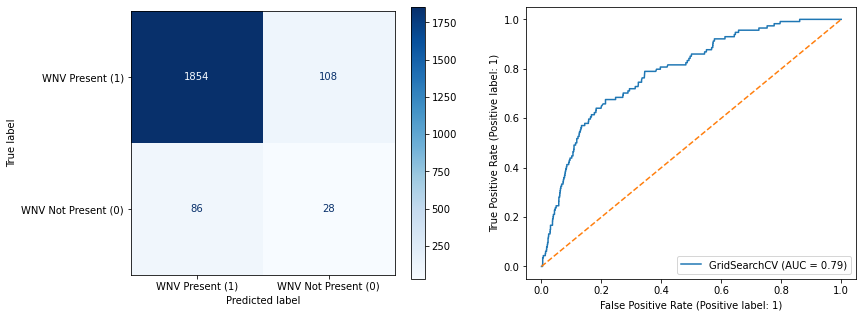

In [69]:
mod_metrics = metrics_and_plot_cm(gs_ada, Xs_val, y_val)

In [70]:
results_df = append_results(results_df,
                           gs_ada.score(Xs_train, y_train),
                           mod_metrics,
                           'AdaBoost',
                           )

In [71]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.755459,0.756262,0.243738,0.789474,0.754332,0.157343,0.262391,0.851818
1,SVM,0.890495,0.848266,0.151734,0.508772,0.867992,0.182965,0.269142,0.822266
2,PCA Logistic Regression,0.754817,0.756262,0.243738,0.763158,0.755861,0.153710,0.255882,0.852842
3,PCA SVM,0.895472,0.756262,0.243738,0.763158,0.755861,0.153710,0.255882,0.852842
4,AdaBoost,0.999358,0.916185,0.083815,0.271930,0.953619,0.254098,0.262712,0.826082
5,AdaBoost,0.999358,0.906551,0.093449,0.245614,0.944954,0.205882,0.224000,0.786684


# Predicting with Test Data

In [163]:
X_train = pd.read_csv('./assets/X_train.csv')
X_train.drop('Unnamed: 0', axis=1, inplace=True)
y_train = pd.read_csv('./assets/y_train.csv')['wnvpresent']
X_test = pd.read_csv('./assets/test.csv')
X_test.drop(['Unnamed: 0','index'], axis=1, inplace=True)
X_test['trap_rank'].fillna(0, inplace=True)
X_test.set_index('id',inplace=True)

In [164]:
sample = pd.read_csv('./assets/X_test.csv')

In [134]:
preds = gs_pca_logreg.predict_proba(X_test)

In [143]:
preds_to_df = pd.DataFrame(preds, columns=['0','1'])
preds_to_df.drop('0',axis=1, inplace=True)

In [150]:
preds_to_df

,1
0,0.020627
1,0.012727
2,0.033267
3,0.006196
4,0.003802
...,...
44545,0.010741
44546,0.028167
44547,0.017367
44548,0.010701


In [157]:
preds_to_df.rename(columns={'1':'Wnvpresent'}, inplace=True)

In [155]:
preds_to_df.index.rename('id', inplace=True)

In [159]:
preds_to_df.to_csv('./assets/results.csv', index=True)

In [165]:
sample

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX SALINARIUS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,8
116289,116290,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX TERRITANS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,8
116290,116291,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX TARSALIS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,8
116291,116292,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",UNSPECIFIED CULEX,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,8


# Feature Importance

In [61]:
# note: svm on rbf has no feature importance, only svm on linear has it
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

Feature Importance based on Logistic Regression

In [62]:
gs_logreg.best_estimator_[1].coef_

array([[ 0.13151225,  0.22051859,  0.89429149,  0.97511   ,  0.12795007,
         0.        ,  1.89975958, -3.41910926,  0.        ,  0.31230264,
         0.51246485,  1.52728542, -0.46734738,  1.15776001, -0.98010352,
         0.06490076,  0.28575877, -0.07339877,  0.        ,  0.38745537,
        -0.16526196,  0.18445876,  0.        ,  0.        , -0.11047549,
         0.        , -0.16511732,  0.        ,  0.        ,  0.32777947,
         0.        , -0.17055463, -3.07289124,  1.63274445, -0.24116256,
         0.08041926]])

In [63]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': logreg_grid.best_estimator_[1].coef_[0]})

# top 20 features
logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

NameError: name 'logreg_grid' is not defined

# Cost Benefit Analysis

# Conclusion

In [ ]:
def model_perform(classifier, X, y):
    
    print(f'Best Score: {classifier.best_score_}')
    print('Best Parameters: ')
    print(classifier.best_params_)
    
    d_scores = {'classifier': classifier}
    
    y_pred = classifier.predict(X)
    y_pred_proba = classifier.predict_proba(X)[:, 1]
    
    
    d_scores['accuracy'] = accuracy_score(y, y_pred)
    d_scores['recall'] = recall_score(y, y_pred)
    d_scores['precision'] = precision_score(y, y_pred)
    d_scores['f1_score'] = f1_score(y, y_pred)
    d_scores['val_roc_auc_score'] = roc_auc_score(y, y_pred_proba)
    
    return d_scores